# Toy likelihood profile code 

### Run MCMC for fake 2d distribution 

The quick start example from Cobaya doesn't seem to do the trick - it's unhappy if I only pass one parameter. I don't fully understand the construction of it so I'm just making up some 2D fake data on a line, adding some Gaussian noise and defining a $\chi^2$ and likelihood on it

In [10]:
import numpy as np

num_points = 200
m = 4
c = 2

noise_mean = 0
noise_sigma = 1
error_size = 5

x = np.linspace(-10,10,num_points)
y = m*x + c + np.random.normal(noise_mean, noise_sigma, num_points)

y_error = np.full(num_points, error_size)

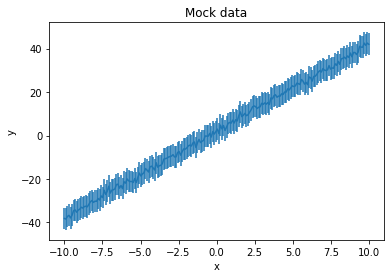

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.errorbar(x=x, y=y, yerr=y_error)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mock data')
plt.show()

In [41]:
def chi_lin_reg(a=0, b=0, x1=x, x2=y, x2_err=y_error):
    chisq = 0.
    for i in range(len(x1)):
        chisq += (x2[i] - a*x1[i] - b)**2/x2_err[i]        
    return chisq


def lkl_lin_reg(a=0, b=0, x1=x, x2=y, x2_err=y_error):
    return np.exp(-chi_lin_reg(a, b, x1, x2, x2_err)/2.)

In [42]:
from scipy.stats import multivariate_normal

def lkl_lin_reg(a=0, b=0):
    return multivariate_normal([4., 2], [[1., 0.3], [0.3, 0.5]]).pdf(np.array([a,b]))

In [43]:
chi_lin_reg(a=20, b=2.332675)

345040.9867065593

In [44]:
lkl_lin_reg(a=20, b=2.332675)

1.7217260452815147e-67

In [45]:
info = {
    'likelihood': {'lin_reg': {
        "external": lkl_lin_reg,}},
    "params": dict([
        ("a", {
            "prior": {"min": -10, "max": 10},
            "proposal": 0.00001,
            "ref": 4.,
            "latex": r"\alpha"}),
        ("b", {
            "prior": {"min": -40, "max": 40},
            "ref": 2,
            "proposal": 0.00001,
            "latex": r"\beta"})]),
    "sampler": {
        "mcmc": { 
            "learn_proposal_Rminus1_max": 1000., 
            "learn_proposal_Rminus1_max_early": 10000.
        }
    }
}


In [46]:
from cobaya.run import run

updated_info, samples = run(info)

[lin_reg] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {lin_reg: 3540.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 10000 (would be 1000 if all params loaded).
[mcmc] Initial point: a:4, b:2
[mcmc] Sampling!
[mcmc] Progress @ 2021-12-15 19:24:27 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 2.312742 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 7.780959 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rat

[root] *WARNING* outlier fraction 0.0005319148936170213 
a = 0.384 +\- 5.805
b = -0.152 +\- 22.111


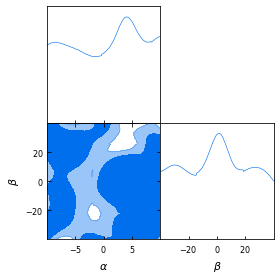

In [47]:
from getdist import mcsamples, plots

settings = {'ignore_rows' : 0.3, 'smooth_scale_1D' : 0.3, 'smooth_scale_2D' : 0.4}
gdsamp = mcsamples.MCSamplesFromCobaya(updated_info, samples.products()["sample"], settings=settings)

print("a = {:.3f} +\- {:.3f}".format(gdsamp.mean('a'), gdsamp.std('a')))
print("b = {:.3f} +\- {:.3f}".format(gdsamp.mean('b'), gdsamp.std('b')))

tri = plots.getSubplotPlotter() 
tri.triangle_plot(
    gdsamp,
    params = ['a','b'],
    legend_loc='upper right',
    filled=True,
)

In [48]:
info["sampler"] = {"minimize": dict([("override_bobyqa", {"seek_global_minimum": True})])}

In [49]:
min_info, results = run(info)

[lin_reg] Initialized external likelihood.
[minimize] Initializing
[minimize] Starting 1/2 random initial point:
[minimize] {'a': 4.0, 'b': 2.0}
[minimize] Starting 2/2 random initial point:
[minimize] {'a': 4.0, 'b': 2.0}
[minimize] Finished successfully!
[minimize] -log(posterior) minimized to 7.1292
[minimize] Parameter values at minimum:
   weight  minuslogpost    a    b  minuslogprior  minuslogprior__0      chi2  chi2__lin_reg
0     1.0      7.129201  4.0  2.0       7.377759          7.377759 -0.497117      -0.497117


In [50]:
best_fit_a = results.minimum.bestfit().a

### Likelihood profile in one direction

Starting from minimum, pick a direction, a limit and an increment and start minimising the likelihood by optimising over all but the lkl profile parameter

In this example, let's fix a (i.e., get a likelihood profile for a) while marginalising over b. 

In [105]:
upper_bound = 10
lower_bound = -10
increment = 0.5

info["sampler"] = {"minimize": dict([("override_bobyqa", {"seek_global_minimum": True})])}

param_current = best_fit_a
lkl_profile_upper = np.array([[0,0]])

while param_current < upper_bound:
    param_current += increment
    info['params']['a']= {'value': param_current, 
                          'latex': r"\alpha"}
    min_info, results = run(info)

    lkl_profile_upper = np.append(lkl_profile_upper, [[param_current, np.exp(-results.minimum.bestfit().minuslogpost)]], axis=0) 
    
param_current = best_fit_a
lkl_profile_lower = np.array([[0,0]])

while param_current > lower_bound:
    param_current -= increment
    info['params']['a']= {'value': param_current, 
                          'latex': r"\alpha"}
    min_info, results = run(info)
    lkl_profile_lower = np.append(lkl_profile_lower, [[param_current, np.exp(-results.minimum.bestfit().minuslogpost)]], axis=0) 

[lin_reg] Initialized external likelihood.
[minimize] Initializing
[minimize] Starting 1/2 random initial point:
[minimize] {'b': 2.0}
[minimize] Starting 2/2 random initial point:
[minimize] {'b': 2.0}
[minimize] Finished successfully!
[minimize] -log(posterior) minimized to 4.16267
[minimize] Parameter values at minimum:
   weight  minuslogpost     b  minuslogprior  minuslogprior__0      chi2  chi2__lin_reg
0     1.0      4.162675  2.15       4.382027          4.382027 -0.438704      -0.438704
[lin_reg] Initialized external likelihood.
[minimize] Initializing
[minimize] Starting 1/2 random initial point:
[minimize] {'b': 2.0}
[minimize] Starting 2/2 random initial point:
[minimize] {'b': 2.0}
[minimize] Finished successfully!
[minimize] -log(posterior) minimized to 4.23127
[minimize] Parameter values at minimum:
   weight  minuslogpost    b  minuslogprior  minuslogprior__0      chi2  chi2__lin_reg
0     1.0      4.231268  2.3       4.382027          4.382027 -0.301516      -0.301516


In [109]:
lkl_profile_upper = lkl_profile_upper[1:,:]
lkl_profile_lower = lkl_profile_lower[1:,:]

In [115]:
lkl_profile = np.append(np.flip(lkl_profile_lower,0), lkl_profile_upper,0)

In [114]:
lkl_profile_upper

array([[ 4.50000002,  0.01556587],
       [ 5.00000002,  0.01453394],
       [ 5.50000002,  0.0135505 ],
       [ 6.00000002,  0.01292764],
       [ 6.50000002,  0.01263726],
       [ 7.00000002,  0.01253456],
       [ 7.50000002,  0.0125068 ],
       [ 8.00000002,  0.01250104],
       [ 8.50000002,  0.01250012],
       [ 9.00000002,  0.01250001],
       [ 9.50000002,  0.0125    ],
       [10.00000002,  0.0125    ]])

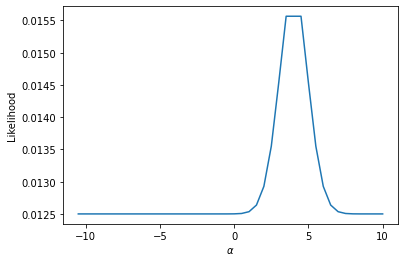

In [116]:
fig, ax = plt.subplots()

ax.plot(lkl_profile[:,0], lkl_profile[:,1])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Likelihood')
plt.show()

- make things modular - have functions to do things so actual executable script is skinny 
- python script call bash using subprocess
- pyhon --> bash --> result --> pyhton stores result and updates yaml --> bash ... 